In [1]:
import os
import numpy as np 
import torch
import torch.nn as nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [31]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # define: encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32, 32, 32
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2), # 32, 16, 16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64, 16, 16
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # 64, 8, 8       
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # 128, 4, 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2) # 256, 2, 2
        )

        # define: decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, 2),  #128, 4, 4
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, 2),  #64, 8, 8
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 2, 2),  #32, 16, 16
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, 2, 2),  #3,32,32
            nn.BatchNorm2d(3),
            nn.Tanh(),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(2*2*256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 50),
#             nn.Linear(8*8*64, 50)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),            
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 2*2*256),
#             nn.Linear(50, 8*8*64)
        )

    def forward(self, x):
        encoded = self.encoder(x)

#         encoded = encoded.view(-1, 8*8*64)
        encoded = encoded.view(-1, 2*2*256)

        encoded = self.fc1(encoded)
        decoded = self.fc2(encoded)

#         decoded = decoded.view(60, 64, 8, 8)
        decoded = decoded.view(60, 256, 2, 2)

        decoded = self.decoder(decoded)

        # Total AE: return latent & reconstruct
        return encoded, decoded


In [9]:
def dump_model(model, model_path):
    dirname = os.path.dirname(model_path)
    if dirname and not os.path.exists(dirname):
        os.makedirs(dirname)

    from datetime import datetime
    now = datetime.now().strftime('%Y%m%d_%H%M')
    p = f'{model_path}_{now}'
    torch.save(model.state_dict(), p)
    print('Model saved to %s' % p)

## Train autoencoder

In [32]:
model_path = "playground/auto-4con2lin.pth"
epochs = 200
lr = 3e-3

In [33]:
if __name__ == '__main__':
    use_gpu = torch.cuda.is_available()
    print(("Using GPU" if use_gpu else "Using CPU"))

    autoencoder = Autoencoder()

    # load data and normalize to [-1, 1]
    trainX = np.load("data/trainX.npy")
    trainX = np.transpose(trainX, (0, 3, 1, 2)) / 255. * 2 - 1
    trainX = torch.Tensor(trainX)

    if use_gpu:
        autoencoder.cuda()
        trainX = trainX.cuda()

    train_dataloader = DataLoader(trainX, batch_size=60, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

    # stop training if (1) finish epochs or (2) loss greater than last 10
    last_loss = 1000
    for epoch in range(epochs):
        cumulate_loss = 0
        for x in train_dataloader:
            latent, reconstruct = autoencoder(x)
            loss = criterion(reconstruct, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cumulate_loss += loss.item() * x.shape[0]

        if epoch % 10 == 9:
            cur_loss = (cumulate_loss / trainX.shape[0])
            print(f'Epoch { "%03d" % (epoch+1) }: Loss: { "%f" % cur_loss }')
            if cur_loss > last_loss:
                break
            else:
                last_loss = cur_loss

    dump_model(autoencoder, model_path)

Using GPU
Epoch 010: Loss: 0.073540
Epoch 020: Loss: 0.063960
Epoch 030: Loss: 0.058282
Epoch 040: Loss: 0.053946
Epoch 050: Loss: 0.051929
Epoch 060: Loss: 0.049801
Epoch 070: Loss: 0.048496
Epoch 080: Loss: 0.047669
Epoch 090: Loss: 0.046478
Epoch 100: Loss: 0.045302
Epoch 110: Loss: 0.044436
Epoch 120: Loss: 0.043772
Epoch 130: Loss: 0.042713
Epoch 140: Loss: 0.041729
Epoch 150: Loss: 0.041191
Epoch 160: Loss: 0.040590
Epoch 170: Loss: 0.040148
Epoch 180: Loss: 0.039430
Epoch 190: Loss: 0.039034
Epoch 200: Loss: 0.038232
Model saved to playground/auto-4con2lin.pth_20191129_0945


## Clustering!!

In [34]:
load_model_path = "playground/auto-2con1lin.pth_20191129_0903"
submit_file_path = "playground/tmp.csv"

In [83]:
def write_ans(result, path):
    print(f'Writing results to {path}')
    dirname = os.path.dirname(path)
    if dirname and not os.path.exists(dirname):
        os.makedirs(dirname)
        
    df = pd.DataFrame({'id': np.arange(0, len(result)), 'label': result})
    df.to_csv(path, index=False)

# if __name__ == '__main__':
use_gpu = torch.cuda.is_available()
print(("Using GPU" if use_gpu else "Using CPU"))

# Load trained model
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load(load_model_path))
# Load images and normalize to [-1, 1]
trainX = np.load('data/trainX.npy')
trainX = np.transpose(trainX, (0, 3, 1, 2)) / 255. * 2 - 1
trainX = torch.Tensor(trainX)

if use_gpu:
    autoencoder.cuda()
    trainX = trainX.cuda()

test_dataloader = DataLoader(trainX, batch_size=60, shuffle=False)

# Collect the latents and standardize it
autoencoder.eval()
latents = []
reconstructs = []
for x in test_dataloader:
    latent, reconstruct = autoencoder(x)
    latents.append(latent.cpu().detach().numpy())
    reconstructs.append(reconstruct.cpu().detach().numpy())

latents = np.concatenate(latents, axis=0).reshape([9000, -1])
latents = (latents - np.mean(latents, axis=0)) / np.std(latents, axis=0)

# Dimension reduction #2
#     print('Starting PCA...')
#     latents = PCA(n_components=32).fit_transform(latents)
print('Starting TSNE...')
latents = TSNE(n_components=2, verbose=1).fit_transform(latents)    
#     latents = TSNE(n_components=8, method='exact').fit_transform(latents)

# Clustering!
# result = KMeans(n_clusters=2).fit(latents).labels_
#     result = SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="nearest_neighbors").fit(latents).labels_

# We know first 5 labels are zeros, it's a mechanism to check are your answers
# need to be flipped or not.
# if np.sum(result[:5]) >= 3:
#     result = 1 - result

# Generate submission
# write_ans(result, submit_file_path)   


Using GPU
Starting TSNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.012s...
[t-SNE] Computed neighbors for 9000 samples in 14.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 1.839267
[t-SNE] KL divergence after 50 iterations with early exaggeration: 93.274590
[t-SNE] KL divergence after 1000 iterations: 3.083680


## Draw!!!

Using GPU


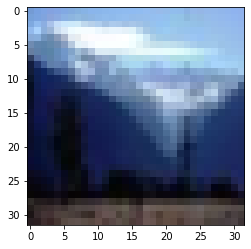

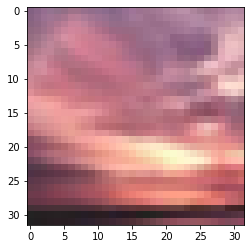

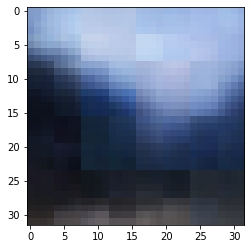

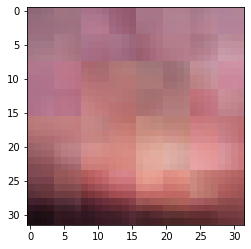

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

if __name__ == '__main__':
    use_gpu = torch.cuda.is_available()
    print(("Using GPU" if use_gpu else "Using CPU"))

    # Load trained model
    autoencoder = Autoencoder()
    autoencoder.load_state_dict(torch.load(load_model_path))
    # Load images and normalize to [-1, 1]
    trainX = np.load('data/trainX.npy')
    plt.imshow(trainX[9])
    plt.show()
    plt.imshow(trainX[10])
    plt.show()
    
    trainX = np.transpose(trainX, (0, 3, 1, 2)) / 255. * 2 - 1
    trainX = torch.Tensor(trainX)
    
    if use_gpu:
        autoencoder.cuda()
        trainX = trainX.cuda()

    test_dataloader = DataLoader(trainX, batch_size=60, shuffle=False)
        
    # Collect the latents and standardize it
    autoencoder.eval()
    latents = []
    reconstructs = []
    for x in test_dataloader:
        latent, reconstruct = autoencoder(x)
        latents.append(latent.cpu().detach().numpy())
        reconstructs.append(reconstruct.cpu().detach().numpy())
        break
        
#     latents = np.concatenate(latents, axis=0).reshape([9000, -1])
#     latents = (latents - np.mean(latents, axis=0)) / np.std(latents, axis=0)
    
    r = (reconstructs[0][9] + 1) / 2 * 255.
    r = np.transpose(r, (1, 2, 0))
    plt.imshow(r.astype('uint8'))
    plt.show()
    
    r2 = (reconstructs[0][10] + 1) / 2 * 255.
    r2 = np.transpose(r2, (1, 2, 0))
    plt.imshow(r2.astype('uint8'))
    plt.show()

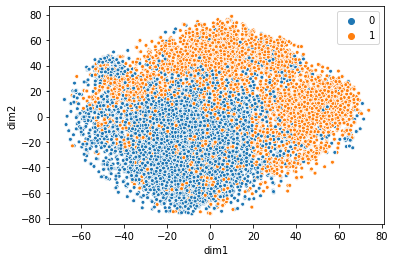

In [102]:
import seaborn as sns

labels = np.load('data/trainY.npy')

sns.scatterplot(x=latents[:,0], y=latents[:,1], hue=labels, s=15)

# tsne_data = np.vstack((latents.T, labels)).T
# tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))
# sn.FacetGrid(tsne_df, hue='label', size=6, ).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.xlabel('dim1')
plt.ylabel('dim2')
plt.show()